# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral

import Sobol: SobolSeq
import LinearAlgebra: norm

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1278
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## Single correlated atom coupled to a bath level

System parameters

In [2]:
β = 1.0;        # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
ϵ = [-0.1, +0.1] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [3]:
nt = 600;
ntau = 5001;
tmax = 1.0;

Exact Diagonalization

In [4]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [5]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [6]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

Pseudo Particle Strong Coupling Expansion

In [7]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

2nd order inchworm diagram on the imaginary branch

In [8]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w = tau_grid[1 + Int(τ_w_pos * (ntau - 1))]

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

Quasi Monte Carlo integration over a $d = 3$ domain

In [9]:
function do_2nd_order_inchworm_diagram(τ_qmc, N, seq)
    qmc_time_ordered_integral(3, contour,
                              τ_i.bpoint, τ_w.bpoint,
                              init = deepcopy(init_0),
                              seq = seq, τ = τ_qmc, N = N) do τ
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        sum
    end
end

do_2nd_order_inchworm_diagram (generic function with 1 method)

## Numerical experiments

In [10]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

# Scan a range of sample numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = zeros(Int, N_points)
    chunks = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for i = 1:N_points
        N = i * N_step
        N_list[i] = N
        
        seq = skip(SobolSeq(3), N - N_step, exact=true)
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N_step, seq)
        chunks[:, i] = [val[s][2][1] for s = 1:4]
        
        println("N = $N, val = ", chunks[:, i])
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_points
        results[:, i] /= i
    end
    (N_list, results)
end

# Scan a range of sample numbers N without optimizations
function scan_N_range_unopt(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = collect(range(N_step, step=N_step, length=N_points))
    results = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for (i, N) in collect(enumerate(N_list))
        N_list[i] = N
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N, SobolSeq(3))
        
        results[:, i] = [val[s][2][1] for s=1:4]
        println("N = $N, res = ", results[:, i])
    end
    (N_list, results)
end

using HDF5
function h5_write_results(group_name, ref, τ_qmc, N_range, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        if group_name in keys(file)
            delete_object(file, group_name)
        end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_range", collect(N_range))
        write(g, "results", results)
        write(g, "div", div)
    end
end

h5_write_results (generic function with 1 method)

In [11]:
τ_qmc = 2.0β
N_step = 10000
N_points = 2000

N_list, results = scan_N_range(τ_qmc, N_step, N_points);

## Check against the unoptimized version
#N_list_unopt, results_unopt = scan_N_range_unopt(τ_qmc, N_step, N_points)
#@assert N_list == N_list_unopt
#@assert isapprox(norm(results - results_unopt, Inf), 0, atol=1e-14)

τ_qmc = 2.0
N = 10000, val = Complex{Float64}[-0.03730102120418184 + 0.0im, -0.03729163507604505 + 0.0im, -0.04078641930661175 + 0.0im, -0.04067387661743166 + 0.0im]
N = 8010000, val = Complex{Float64}[-0.03728974289451798 + 0.0im, -0.037236574366044245 + 0.0im, -0.040801996692368454 + 0.0im, -0.040620915932741336 + 0.0im]
N = 10010000, val = Complex{Float64}[-0.03862431693408244 + 0.0im, -0.038573625748795394 + 0.0im, -0.042805535781921755 + 0.0im, -0.04270378059602777 + 0.0im]
N = 4010000, val = Complex{Float64}[-0.03822436552150644 + 0.0im, -0.0382115035608648 + 0.0im, -0.042037678490988065 + 0.0im, -0.04195800679353147 + 0.0im]
N = 6010000, val = Complex{Float64}[-0.04090897796462383 + 0.0im, -0.04083892851624959 + 0.0im, -0.046238893642569695 + 0.0im, -0.046077658646815706 + 0.0im]
N = 12010000, val = Complex{Float64}[-0.040652994889500756 + 0.0im, -0.040802122016057284 + 0.0im, -0.04524589951065645 + 0.0im, -0.04575486543307856 + 0.0im]
N = 2010000, val = Complex{Float64}[-0.0370

N = 70000, val = Complex{Float64}[-0.03565722648413337 + 0.0im, -0.03536354589492304 + 0.0im, -0.03913523051016286 + 0.0im, -0.03822631894824252 + 0.0im]
N = 14060000, val = Complex{Float64}[-0.038773196599178925 + 0.0im, -0.03878099732113033 + 0.0im, -0.042498218776197125 + 0.0im, -0.042384006516089714 + 0.0im]
N = 6060000, val = Complex{Float64}[-0.03759157848546733 + 0.0im, -0.03751178853900786 + 0.0im, -0.04191079706683244 + 0.0im, -0.04163855706759344 + 0.0im]
N = 12060000, val = Complex{Float64}[-0.042769346659500086 + 0.0im, -0.04308286425983548 + 0.0im, -0.047267849659629706 + 0.0im, -0.04818355842086826 + 0.0im]
N = 2060000, val = Complex{Float64}[-0.04076952875633208 + 0.0im, -0.04087322522067171 + 0.0im, -0.044800396307407106 + 0.0im, -0.04503012955851183 + 0.0im]
N = 18060000, val = Complex{Float64}[-0.03764514670870583 + 0.0im, -0.037446069764306644 + 0.0im, -0.04146852046651512 + 0.0im, -0.040726126805628066 + 0.0im]
N = 16060000, val = Complex{Float64}[-0.037633134209563

N = 150000, val = Complex{Float64}[-0.03536856885253845 + 0.0im, -0.035253022080222324 + 0.0im, -0.03833277270905382 + 0.0im, -0.0379885259946293 + 0.0im]
N = 2120000, val = Complex{Float64}[-0.0352294512118016 + 0.0im, -0.03496147785025956 + 0.0im, -0.03841880843781977 + 0.0im, -0.03762035016858854 + 0.0im]
N = 14120000, val = Complex{Float64}[-0.039051541495295626 + 0.0im, -0.038847141497708605 + 0.0im, -0.04329863784203488 + 0.0im, -0.04263084385022282 + 0.0im]
N = 6120000, val = Complex{Float64}[-0.03613968067109477 + 0.0im, -0.035892680419011114 + 0.0im, -0.03975753047977829 + 0.0im, -0.03897177537588871 + 0.0im]
N = 16120000, val = Complex{Float64}[-0.03833647064783797 + 0.0im, -0.038381060324636694 + 0.0im, -0.041790706447639984 + 0.0im, -0.04189236467179904 + 0.0im]
N = 18130000, val = Complex{Float64}[-0.04024368731550436 + 0.0im, -0.040432787601495816 + 0.0im, -0.0444900893907025 + 0.0im, -0.04510944796397681 + 0.0im]
N = 12120000, val = Complex{Float64}[-0.038689029946725184

N = 220000, val = Complex{Float64}[-0.042160305866569575 + 0.0im, -0.04232266698334259 + 0.0im, -0.04686634589171722 + 0.0im, -0.04730653535348261 + 0.0im]
N = 6170000, val = Complex{Float64}[-0.03835298015740502 + 0.0im, -0.03840265471009082 + 0.0im, -0.041775615847672976 + 0.0im, -0.041904217005361906 + 0.0im]
N = 2170000, val = Complex{Float64}[-0.035249329000371664 + 0.0im, -0.03498233035693713 + 0.0im, -0.0383987940741193 + 0.0im, -0.037504173262563965 + 0.0im]
N = 4180000, val = Complex{Float64}[-0.04078362059891884 + 0.0im, -0.040929910769159576 + 0.0im, -0.04478122441790618 + 0.0im, -0.045138114796451995 + 0.0im]
N = 8180000, val = Complex{Float64}[-0.03816931230847439 + 0.0im, -0.0380585329954654 + 0.0im, -0.04209802400161067 + 0.0im, -0.04173715368211594 + 0.0im]
N = 230000, val = Complex{Float64}[-0.03634949298489914 + 0.0im, -0.03621272200691524 + 0.0im, -0.03927946143649803 + 0.0im, -0.03886589852935262 + 0.0im]
N = 18190000, val = Complex{Float64}[-0.04150599713619098 + 0

N = 290000, val = Complex{Float64}[-0.03828149740459619 + 0.0im, -0.03830165900237502 + 0.0im, -0.041910527285951175 + 0.0im, -0.04199249472964304 + 0.0im]
N = 12230000, val = Complex{Float64}[-0.03617381716611933 + 0.0im, -0.03603764773825399 + 0.0im, -0.0399756100462518 + 0.0im, -0.039466276462799384 + 0.0im]
N = 10240000, val = Complex{Float64}[-0.03986095241178696 + 0.0im, -0.04003030345480971 + 0.0im, -0.043568410035998754 + 0.0im, -0.044060279889861935 + 0.0im]
N = 18240000, val = Complex{Float64}[-0.03901628271343268 + 0.0im, -0.038866245442283606 + 0.0im, -0.04355677715513142 + 0.0im, -0.043050354148220685 + 0.0im]
N = 14230000, val = Complex{Float64}[-0.037626356995058195 + 0.0im, -0.03747486391927304 + 0.0im, -0.04153793874760282 + 0.0im, -0.041095536690203945 + 0.0im]
N = 8240000, val = Complex{Float64}[-0.0370904806750759 + 0.0im, -0.036958074014488786 + 0.0im, -0.04124122180356097 + 0.0im, -0.04085622370037079 + 0.0im]
N = 2230000, val = Complex{Float64}[-0.039110676973775

N = 350000, val = Complex{Float64}[-0.04101758329467491 + 0.0im, -0.04104826347681341 + 0.0im, -0.04602965200484203 + 0.0im, -0.04609981759645275 + 0.0im]
N = 10290000, val = Complex{Float64}[-0.034332381136904275 + 0.0im, -0.03418376994963006 + 0.0im, -0.037371028148009224 + 0.0im, -0.0369163584065899 + 0.0im]
N = 6280000, val = Complex{Float64}[-0.04002472043217897 + 0.0im, -0.03994557703626286 + 0.0im, -0.04469890165401134 + 0.0im, -0.04451089481781163 + 0.0im]
N = 14280000, val = Complex{Float64}[-0.04468235313668443 + 0.0im, -0.0449981116099353 + 0.0im, -0.0496339626880529 + 0.0im, -0.05054933445350023 + 0.0im]
N = 18300000, val = Complex{Float64}[-0.03986082371771105 + 0.0im, -0.040057516351015315 + 0.0im, -0.0436089018082437 + 0.0im, -0.044183440190746534 + 0.0im]
N = 4290000, val = Complex{Float64}[-0.037158520403299915 + 0.0im, -0.037128675757405534 + 0.0im, -0.04113383943116972 + 0.0im, -0.04114783736102416 + 0.0im]
N = 2280000, val = Complex{Float64}[-0.038650681680616805 + 

N = 420000, val = Complex{Float64}[-0.04060695853408585 + 0.0im, -0.04070778429832296 + 0.0im, -0.04521806422350126 + 0.0im, -0.04560662315632171 + 0.0im]
N = 4340000, val = Complex{Float64}[-0.03768728739595634 + 0.0im, -0.03759795321326496 + 0.0im, -0.041645860845997515 + 0.0im, -0.041319284320134764 + 0.0im]
N = 2330000, val = Complex{Float64}[-0.0336682315497231 + 0.0im, -0.033315854830241534 + 0.0im, -0.036949070622113764 + 0.0im, -0.03591560554318487 + 0.0im]
N = 6330000, val = Complex{Float64}[-0.04457205200949053 + 0.0im, -0.04481880687292002 + 0.0im, -0.049814891950302045 + 0.0im, -0.050731593111342586 + 0.0im]
N = 18350000, val = Complex{Float64}[-0.04085508510278557 + 0.0im, -0.04113142788855356 + 0.0im, -0.04480644013262946 + 0.0im, -0.04562538533381911 + 0.0im]
N = 10350000, val = Complex{Float64}[-0.040343534634518875 + 0.0im, -0.04050430648170502 + 0.0im, -0.04416189487098536 + 0.0im, -0.044526302655741264 + 0.0im]
N = 8350000, val = Complex{Float64}[-0.03981686544428724

N = 480000, val = Complex{Float64}[-0.04013416870373391 + 0.0im, -0.040177830737529986 + 0.0im, -0.04464521838505319 + 0.0im, -0.04478623413965058 + 0.0im]
N = 16370000, val = Complex{Float64}[-0.03889905706901259 + 0.0im, -0.03867814397045131 + 0.0im, -0.04388688586723828 + 0.0im, -0.04320624044346235 + 0.0im]
N = 18400000, val = Complex{Float64}[-0.03770811876178995 + 0.0im, -0.03762087076249225 + 0.0im, -0.0414437079843282 + 0.0im, -0.04114768987678749 + 0.0im]
N = 6380000, val = Complex{Float64}[-0.03804438577326493 + 0.0im, -0.037953510445289725 + 0.0im, -0.04261475237449767 + 0.0im, -0.04228450304725658 + 0.0im]
N = 4390000, val = Complex{Float64}[-0.04163985154190183 + 0.0im, -0.041780931439936324 + 0.0im, -0.046264685265296264 + 0.0im, -0.04673789361536308 + 0.0im]
N = 2380000, val = Complex{Float64}[-0.03630508303296869 + 0.0im, -0.03628946461375299 + 0.0im, -0.039754673088789855 + 0.0im, -0.039721962279536206 + 0.0im]
N = 10410000, val = Complex{Float64}[-0.03730116059674625 

N = 6430000, val = Complex{Float64}[-0.03809250170185289 + 0.0im, -0.03795868311946502 + 0.0im, -0.042262288523235936 + 0.0im, -0.04202990809407106 + 0.0im]
N = 14430000, val = Complex{Float64}[-0.038136914727612825 + 0.0im, -0.038096931334559984 + 0.0im, -0.042218591338889735 + 0.0im, -0.042169098592511174 + 0.0im]
N = 10460000, val = Complex{Float64}[-0.03511978920817407 + 0.0im, -0.034950504418869384 + 0.0im, -0.03902997318050151 + 0.0im, -0.038517801168525725 + 0.0im]
N = 8460000, val = Complex{Float64}[-0.03668608520295302 + 0.0im, -0.03644306408045488 + 0.0im, -0.040184397067903874 + 0.0im, -0.03938124133290113 + 0.0im]
N = 4440000, val = Complex{Float64}[-0.040164578038492556 + 0.0im, -0.040267930274352846 + 0.0im, -0.044536475036964646 + 0.0im, -0.044892737913189984 + 0.0im]
N = 18460000, val = Complex{Float64}[-0.04004702642450001 + 0.0im, -0.039988748628028994 + 0.0im, -0.0446999198196284 + 0.0im, -0.044550816080895145 + 0.0im]
N = 16430000, val = Complex{Float64}[-0.04214746

N = 610000, val = Complex{Float64}[-0.039664102819855836 + 0.0im, -0.039705503369492495 + 0.0im, -0.043899099345849804 + 0.0im, -0.04406147827279152 + 0.0im]
N = 10520000, val = Complex{Float64}[-0.042783977820474245 + 0.0im, -0.043085201465409194 + 0.0im, -0.0471583385476649 + 0.0im, -0.04807124748687784 + 0.0im]
N = 2480000, val = Complex{Float64}[-0.04119963214435797 + 0.0im, -0.04141771978095937 + 0.0im, -0.045887319880430696 + 0.0im, -0.04653621768030904 + 0.0im]
N = 14490000, val = Complex{Float64}[-0.036691665868803576 + 0.0im, -0.03649092789302961 + 0.0im, -0.04026246521424917 + 0.0im, -0.03955738646854809 + 0.0im]
N = 8530000, val = Complex{Float64}[-0.04012486940214173 + 0.0im, -0.04019493916511682 + 0.0im, -0.044669671978456026 + 0.0im, -0.044895649477144944 + 0.0im]
N = 6490000, val = Complex{Float64}[-0.039883718202441666 + 0.0im, -0.0399868017959539 + 0.0im, -0.043355253503629676 + 0.0im, -0.043622734096863215 + 0.0im]
N = 18520000, val = Complex{Float64}[-0.0366756012385

N = 14540000, val = Complex{Float64}[-0.04263684993189052 + 0.0im, -0.04280831927480064 + 0.0im, -0.047425553353618054 + 0.0im, -0.04800544476253733 + 0.0im]
N = 10580000, val = Complex{Float64}[-0.03697277129065408 + 0.0im, -0.03679632082714843 + 0.0im, -0.04152002553368912 + 0.0im, -0.041089421642008545 + 0.0im]
N = 8600000, val = Complex{Float64}[-0.03864891367469664 + 0.0im, -0.03871632710001628 + 0.0im, -0.04302633468932167 + 0.0im, -0.0432686127171701 + 0.0im]
N = 18570000, val = Complex{Float64}[-0.03648333637741954 + 0.0im, -0.0362428005443609 + 0.0im, -0.04083468444934957 + 0.0im, -0.040227524185470855 + 0.0im]
N = 4550000, val = Complex{Float64}[-0.03628580848805833 + 0.0im, -0.03618986608981343 + 0.0im, -0.03967140113299804 + 0.0im, -0.039367367035237834 + 0.0im]
N = 2540000, val = Complex{Float64}[-0.039342607935943415 + 0.0im, -0.03947440434746567 + 0.0im, -0.0429800335131313 + 0.0im, -0.04346991571962664 + 0.0im]
N = 12560000, val = Complex{Float64}[-0.03678756682266905 +

N = 4600000, val = Complex{Float64}[-0.04160665186527787 + 0.0im, -0.041603664402870964 + 0.0im, -0.04615789239390101 + 0.0im, -0.04615376781692843 + 0.0im]
N = 10630000, val = Complex{Float64}[-0.03814374923786262 + 0.0im, -0.03804388706776333 + 0.0im, -0.04224150913316237 + 0.0im, -0.04185284518561342 + 0.0im]
N = 14600000, val = Complex{Float64}[-0.03733997375624674 + 0.0im, -0.037348046030931316 + 0.0im, -0.04073628655991236 + 0.0im, -0.040691005991120084 + 0.0im]
N = 6600000, val = Complex{Float64}[-0.03920966399326904 + 0.0im, -0.039209283266762276 + 0.0im, -0.043109104721880245 + 0.0im, -0.043033957327413816 + 0.0im]
N = 12610000, val = Complex{Float64}[-0.036688107003402054 + 0.0im, -0.036548509592999566 + 0.0im, -0.0403314776237409 + 0.0im, -0.039793759752841 + 0.0im]
N = 18620000, val = Complex{Float64}[-0.03958673123621 + 0.0im, -0.03959762032236782 + 0.0im, -0.044148765923937766 + 0.0im, -0.04413805657118995 + 0.0im]
N = 2590000, val = Complex{Float64}[-0.03413478070226109 

N = 8710000, val = Complex{Float64}[-0.03973982387035477 + 0.0im, -0.039858006844656235 + 0.0im, -0.04390362455892758 + 0.0im, -0.044383523602876764 + 0.0im]
N = 6660000, val = Complex{Float64}[-0.038096453548888756 + 0.0im, -0.03795873821096679 + 0.0im, -0.0421930495152047 + 0.0im, -0.04179593507486678 + 0.0im]
N = 4660000, val = Complex{Float64}[-0.04212785778624773 + 0.0im, -0.04231927360957036 + 0.0im, -0.04694350408145103 + 0.0im, -0.04759127011595387 + 0.0im]
N = 2650000, val = Complex{Float64}[-0.039291751206542345 + 0.0im, -0.03929642671246254 + 0.0im, -0.04286996597043842 + 0.0im, -0.04285185560890464 + 0.0im]
N = 12670000, val = Complex{Float64}[-0.040074648236305056 + 0.0im, -0.040144014428716 + 0.0im, -0.044887244095659765 + 0.0im, -0.04509794530762716 + 0.0im]
N = 18680000, val = Complex{Float64}[-0.03673512635044843 + 0.0im, -0.03659313414613734 + 0.0im, -0.040174902517745664 + 0.0im, -0.0397253561064574 + 0.0im]
N = 16650000, val = Complex{Float64}[-0.0368355165759922 + 

N = 890000, val = Complex{Float64}[-0.04116732886140716 + 0.0im, -0.04130840189085397 + 0.0im, -0.045742701650023636 + 0.0im, -0.04620045926485754 + 0.0im]
N = 8780000, val = Complex{Float64}[-0.03735985199959456 + 0.0im, -0.03731058423509995 + 0.0im, -0.040439685186101054 + 0.0im, -0.04024422720421732 + 0.0im]
N = 4720000, val = Complex{Float64}[-0.040669492616300255 + 0.0im, -0.04071841363343169 + 0.0im, -0.044916418073393874 + 0.0im, -0.045169111098958964 + 0.0im]
N = 14730000, val = Complex{Float64}[-0.03604765107198647 + 0.0im, -0.03585934378421835 + 0.0im, -0.04032873038143977 + 0.0im, -0.03976432013371507 + 0.0im]
N = 6720000, val = Complex{Float64}[-0.038687249551201806 + 0.0im, -0.03869936205392694 + 0.0im, -0.04283346572233428 + 0.0im, -0.04276588502891337 + 0.0im]
N = 16710000, val = Complex{Float64}[-0.03926810713329295 + 0.0im, -0.0393470365028242 + 0.0im, -0.04319914190119166 + 0.0im, -0.043447006487214196 + 0.0im]
N = 18740000, val = Complex{Float64}[-0.03760158753985461

N = 960000, val = Complex{Float64}[-0.0381675791512808 + 0.0im, -0.03805528982027832 + 0.0im, -0.04200029837694296 + 0.0im, -0.04165963633597158 + 0.0im]
N = 14780000, val = Complex{Float64}[-0.039151392795083596 + 0.0im, -0.03912938452002709 + 0.0im, -0.043333923876684985 + 0.0im, -0.04331139133012925 + 0.0im]
N = 16760000, val = Complex{Float64}[-0.03863703564021801 + 0.0im, -0.03856301994215201 + 0.0im, -0.042823616268338915 + 0.0im, -0.04256893167506589 + 0.0im]
N = 10800000, val = Complex{Float64}[-0.03720810755496416 + 0.0im, -0.03713773205835765 + 0.0im, -0.04092839345104993 + 0.0im, -0.040718514917318274 + 0.0im]
N = 4770000, val = Complex{Float64}[-0.039713278039779275 + 0.0im, -0.03980101181989436 + 0.0im, -0.044009123430280024 + 0.0im, -0.0442254045811365 + 0.0im]
N = 2770000, val = Complex{Float64}[-0.03677273685743423 + 0.0im, -0.03669207461479348 + 0.0im, -0.04028740462319113 + 0.0im, -0.03990430812089871 + 0.0im]
N = 18790000, val = Complex{Float64}[-0.040795972949894246

N = 1020000, val = Complex{Float64}[-0.03509589432942097 + 0.0im, -0.03482036348825952 + 0.0im, -0.03880802667866467 + 0.0im, -0.03799867504805147 + 0.0im]
N = 8890000, val = Complex{Float64}[-0.035657343998855257 + 0.0im, -0.03548219762990487 + 0.0im, -0.03940691306772895 + 0.0im, -0.03883717243885891 + 0.0im]
N = 16810000, val = Complex{Float64}[-0.03959808952808779 + 0.0im, -0.03955122403455066 + 0.0im, -0.04401028474110608 + 0.0im, -0.043936169204767894 + 0.0im]
N = 14830000, val = Complex{Float64}[-0.0367249821389208 + 0.0im, -0.03667194235951401 + 0.0im, -0.04047489604938096 + 0.0im, -0.04037052154264545 + 0.0im]
N = 4820000, val = Complex{Float64}[-0.04028725850530364 + 0.0im, -0.04046077439227368 + 0.0im, -0.04427566003629852 + 0.0im, -0.04481977901088514 + 0.0im]
N = 10850000, val = Complex{Float64}[-0.03879313036321635 + 0.0im, -0.038748979611115814 + 0.0im, -0.04223719679183824 + 0.0im, -0.042111325643780936 + 0.0im]
N = 18840000, val = Complex{Float64}[-0.03676296494750651 

N = 1090000, val = Complex{Float64}[-0.042165389453645674 + 0.0im, -0.04235952131708078 + 0.0im, -0.046819347269851784 + 0.0im, -0.04740397930427722 + 0.0im]
N = 2870000, val = Complex{Float64}[-0.04031836116816515 + 0.0im, -0.04053256216832035 + 0.0im, -0.04427375747555148 + 0.0im, -0.044894187477075104 + 0.0im]
N = 6880000, val = Complex{Float64}[-0.03708662190376585 + 0.0im, -0.03693186151221658 + 0.0im, -0.04127733038737554 + 0.0im, -0.04082236298328749 + 0.0im]
N = 16870000, val = Complex{Float64}[-0.03725724750130528 + 0.0im, -0.03714373863188285 + 0.0im, -0.04073356831768507 + 0.0im, -0.04035561215667486 + 0.0im]
N = 4880000, val = Complex{Float64}[-0.037113041883791574 + 0.0im, -0.036976189678484955 + 0.0im, -0.04112331628641814 + 0.0im, -0.04079033107707549 + 0.0im]
N = 8960000, val = Complex{Float64}[-0.03774334473170948 + 0.0im, -0.03762965134782716 + 0.0im, -0.04126181781791259 + 0.0im, -0.04093407478617155 + 0.0im]
N = 10910000, val = Complex{Float64}[-0.03855408832418156 

N = 1150000, val = Complex{Float64}[-0.040137007055631446 + 0.0im, -0.04017986541069093 + 0.0im, -0.04454577599801346 + 0.0im, -0.04470407693832578 + 0.0im]
N = 6930000, val = Complex{Float64}[-0.03904409128200521 + 0.0im, -0.03901722976131502 + 0.0im, -0.04364898688510384 + 0.0im, -0.0436680914702256 + 0.0im]
N = 10960000, val = Complex{Float64}[-0.03928462385165664 + 0.0im, -0.03932652902935314 + 0.0im, -0.043037788993527164 + 0.0im, -0.043158161043565395 + 0.0im]
N = 12950000, val = Complex{Float64}[-0.03868280816668766 + 0.0im, -0.03868275674103806 + 0.0im, -0.042739401204889116 + 0.0im, -0.042736905226278384 + 0.0im]
N = 2920000, val = Complex{Float64}[-0.043660962837252196 + 0.0im, -0.04394833952895251 + 0.0im, -0.048588527168925984 + 0.0im, -0.049470457528169816 + 0.0im]
N = 4930000, val = Complex{Float64}[-0.03640506330753899 + 0.0im, -0.036363982382741473 + 0.0im, -0.03944319189653825 + 0.0im, -0.03925076997551131 + 0.0im]
N = 14940000, val = Complex{Float64}[-0.04077337012806

N = 1220000, val = Complex{Float64}[-0.03960227469687313 + 0.0im, -0.03952829894174769 + 0.0im, -0.04391611351611017 + 0.0im, -0.043701207552111695 + 0.0im]
N = 6980000, val = Complex{Float64}[-0.036176856781144254 + 0.0im, -0.036004419013871074 + 0.0im, -0.03976877889454692 + 0.0im, -0.03920719373346792 + 0.0im]
N = 2970000, val = Complex{Float64}[-0.03974438949395536 + 0.0im, -0.03983529841026037 + 0.0im, -0.043838745968028205 + 0.0im, -0.044002701930422286 + 0.0im]
N = 13000000, val = Complex{Float64}[-0.03973387725859418 + 0.0im, -0.03978553083396788 + 0.0im, -0.04366004362503748 + 0.0im, -0.043829565450571914 + 0.0im]
N = 9070000, val = Complex{Float64}[-0.04086058224382324 + 0.0im, -0.04108321822351024 + 0.0im, -0.0446941538877912 + 0.0im, -0.045383010185240574 + 0.0im]
N = 14990000, val = Complex{Float64}[-0.03818198139195024 + 0.0im, -0.0380724504081788 + 0.0im, -0.041916004829795364 + 0.0im, -0.04159574330338601 + 0.0im]
N = 11020000, val = Complex{Float64}[-0.0362659275768758

N = 17030000, val = Complex{Float64}[-0.03778256681615366 + 0.0im, -0.037733232551168054 + 0.0im, -0.04128388338063212 + 0.0im, -0.041079794902999824 + 0.0im]
N = 19050000, val = Complex{Float64}[-0.03876971695116087 + 0.0im, -0.03873545533889093 + 0.0im, -0.04237035433231733 + 0.0im, -0.04222098594091232 + 0.0im]
N = 9130000, val = Complex{Float64}[-0.038835816974315665 + 0.0im, -0.03893893144404662 + 0.0im, -0.04242783267451136 + 0.0im, -0.04267571009675349 + 0.0im]
N = 7040000, val = Complex{Float64}[-0.039818187493879616 + 0.0im, -0.03989339663204653 + 0.0im, -0.043457064611114066 + 0.0im, -0.04370152437371616 + 0.0im]
N = 3030000, val = Complex{Float64}[-0.03906481209362094 + 0.0im, -0.038995085204019286 + 0.0im, -0.04362687225174168 + 0.0im, -0.04341264546778341 + 0.0im]
N = 5050000, val = Complex{Float64}[-0.037062038015865995 + 0.0im, -0.03690178023789783 + 0.0im, -0.04128983576845105 + 0.0im, -0.04084262291309776 + 0.0im]
N = 13060000, val = Complex{Float64}[-0.038289589286095

N = 1350000, val = Complex{Float64}[-0.04211579745090935 + 0.0im, -0.04241705772723164 + 0.0im, -0.04720215689968435 + 0.0im, -0.04823857369711855 + 0.0im]
N = 17090000, val = Complex{Float64}[-0.038243651579548406 + 0.0im, -0.038181769808479274 + 0.0im, -0.04182688125907834 + 0.0im, -0.04160459510876754 + 0.0im]
N = 19110000, val = Complex{Float64}[-0.03706785029866402 + 0.0im, -0.03683310225455585 + 0.0im, -0.04110923897581601 + 0.0im, -0.04030714388456234 + 0.0im]
N = 7100000, val = Complex{Float64}[-0.03817970147225939 + 0.0im, -0.038153181169326957 + 0.0im, -0.042171823322142823 + 0.0im, -0.042133156901649906 + 0.0im]
N = 15110000, val = Complex{Float64}[-0.03811694885772636 + 0.0im, -0.03805261462889285 + 0.0im, -0.042371837320519835 + 0.0im, -0.04210093970676616 + 0.0im]
N = 13120000, val = Complex{Float64}[-0.03979883230836904 + 0.0im, -0.0399315693653612 + 0.0im, -0.04368454278960657 + 0.0im, -0.04414878766296901 + 0.0im]
N = 9200000, val = Complex{Float64}[-0.0386021524247257

N = 1420000, val = Complex{Float64}[-0.03970056285832975 + 0.0im, -0.039761209646911225 + 0.0im, -0.043872407627323404 + 0.0im, -0.044088068930741485 + 0.0im]
N = 11190000, val = Complex{Float64}[-0.03949967218845265 + 0.0im, -0.03941836182471016 + 0.0im, -0.044240992361341665 + 0.0im, -0.044120962770245506 + 0.0im]
N = 3160000, val = Complex{Float64}[-0.038335620681582104 + 0.0im, -0.03849768923024968 + 0.0im, -0.04203273907118797 + 0.0im, -0.04258918164894905 + 0.0im]
N = 7160000, val = Complex{Float64}[-0.04024967607879136 + 0.0im, -0.040387592008112 + 0.0im, -0.044385705157460396 + 0.0im, -0.04474217528992258 + 0.0im]
N = 19170000, val = Complex{Float64}[-0.04209001075866029 + 0.0im, -0.042229117553074735 + 0.0im, -0.04697411600611979 + 0.0im, -0.04755909928825717 + 0.0im]
N = 13180000, val = Complex{Float64}[-0.03874858780865389 + 0.0im, -0.038738933149881964 + 0.0im, -0.04245881203973277 + 0.0im, -0.04228372809208947 + 0.0im]
N = 9260000, val = Complex{Float64}[-0.041204406124087

N = 1480000, val = Complex{Float64}[-0.03870456802205818 + 0.0im, -0.03872886398754916 + 0.0im, -0.04278553978523487 + 0.0im, -0.042780963962956234 + 0.0im]
N = 7210000, val = Complex{Float64}[-0.03577500392797338 + 0.0im, -0.03556822736461096 + 0.0im, -0.038921485918644805 + 0.0im, -0.03826508260542415 + 0.0im]
N = 5230000, val = Complex{Float64}[-0.038273868561472205 + 0.0im, -0.038284180734472456 + 0.0im, -0.041961142878214286 + 0.0im, -0.04197304864423221 + 0.0im]
N = 17200000, val = Complex{Float64}[-0.03921552249890855 + 0.0im, -0.03927138052895569 + 0.0im, -0.043264253201534805 + 0.0im, -0.043414605352038456 + 0.0im]
N = 15220000, val = Complex{Float64}[-0.03930409272049506 + 0.0im, -0.03933966884684633 + 0.0im, -0.04298588371806525 + 0.0im, -0.043055528924130886 + 0.0im]
N = 19230000, val = Complex{Float64}[-0.03674294106902939 + 0.0im, -0.03667032091140765 + 0.0im, -0.040296560245078245 + 0.0im, -0.040048974154260446 + 0.0im]
N = 11250000, val = Complex{Float64}[-0.03818631168

N = 1540000, val = Complex{Float64}[-0.03706929946201875 + 0.0im, -0.036880301483527965 + 0.0im, -0.04118649240622075 + 0.0im, -0.040612109664969503 + 0.0im]
N = 19280000, val = Complex{Float64}[-0.03746163530147474 + 0.0im, -0.037546610062065396 + 0.0im, -0.0403175686783567 + 0.0im, -0.0405643266490542 + 0.0im]
N = 9370000, val = Complex{Float64}[-0.039807380726330444 + 0.0im, -0.039945012062336895 + 0.0im, -0.04373525969943662 + 0.0im, -0.044166687585657914 + 0.0im]
N = 13280000, val = Complex{Float64}[-0.03924426637831782 + 0.0im, -0.03930053640782024 + 0.0im, -0.043240342735258314 + 0.0im, -0.043351829100400176 + 0.0im]
N = 17260000, val = Complex{Float64}[-0.03909899372493482 + 0.0im, -0.039134637368449826 + 0.0im, -0.043672687422911034 + 0.0im, -0.043939871664728104 + 0.0im]
N = 15280000, val = Complex{Float64}[-0.03780162190443908 + 0.0im, -0.03774704200496333 + 0.0im, -0.04116369022337874 + 0.0im, -0.04090784389116868 + 0.0im]
N = 3280000, val = Complex{Float64}[-0.041183324824

N = 1610000, val = Complex{Float64}[-0.042791241293898885 + 0.0im, -0.04321536107039341 + 0.0im, -0.04751620396442632 + 0.0im, -0.048712033028929486 + 0.0im]
N = 17320000, val = Complex{Float64}[-0.04280340919797498 + 0.0im, -0.043105671694340826 + 0.0im, -0.047119621718809186 + 0.0im, -0.047998649599740255 + 0.0im]
N = 11370000, val = Complex{Float64}[-0.03858493304976946 + 0.0im, -0.03854103700544484 + 0.0im, -0.043017853837541184 + 0.0im, -0.042920595727526885 + 0.0im]
N = 9440000, val = Complex{Float64}[-0.04173957004305908 + 0.0im, -0.041943800697114404 + 0.0im, -0.046108303980273706 + 0.0im, -0.04677495413948567 + 0.0im]
N = 7330000, val = Complex{Float64}[-0.040135601194467824 + 0.0im, -0.040144672553370356 + 0.0im, -0.04442066090541562 + 0.0im, -0.044495516373030855 + 0.0im]
N = 15340000, val = Complex{Float64}[-0.038081914638971294 + 0.0im, -0.037995475473420845 + 0.0im, -0.04235353580200809 + 0.0im, -0.042168402136856256 + 0.0im]
N = 3340000, val = Complex{Float64}[-0.0397728

N = 1680000, val = Complex{Float64}[-0.03921075146206336 + 0.0im, -0.03922945328843285 + 0.0im, -0.04331995334658694 + 0.0im, -0.04336656577913725 + 0.0im]
N = 9500000, val = Complex{Float64}[-0.03771371153972599 + 0.0im, -0.03770065399886493 + 0.0im, -0.041632637170166874 + 0.0im, -0.04158809422453508 + 0.0im]
N = 11430000, val = Complex{Float64}[-0.04130023324895116 + 0.0im, -0.041497599634226084 + 0.0im, -0.04535769837165123 + 0.0im, -0.045884116381623145 + 0.0im]
N = 5400000, val = Complex{Float64}[-0.0393484589095127 + 0.0im, -0.03950058923590296 + 0.0im, -0.04292710762774706 + 0.0im, -0.04348216497775214 + 0.0im]
N = 17380000, val = Complex{Float64}[-0.03966920706957214 + 0.0im, -0.03980134475096477 + 0.0im, -0.044064014947070455 + 0.0im, -0.044453991772960395 + 0.0im]
N = 7390000, val = Complex{Float64}[-0.03716927331061927 + 0.0im, -0.03698482126273847 + 0.0im, -0.04084425788117767 + 0.0im, -0.04017470012110088 + 0.0im]
N = 15400000, val = Complex{Float64}[-0.04085247248913808 

N = 1750000, val = Complex{Float64}[-0.037621198452005726 + 0.0im, -0.03749079382003084 + 0.0im, -0.04165446129751642 + 0.0im, -0.0412019107445004 + 0.0im]
N = 9570000, val = Complex{Float64}[-0.03873901890389679 + 0.0im, -0.03881324173822944 + 0.0im, -0.0426891038131729 + 0.0im, -0.04295089140847008 + 0.0im]
N = 15460000, val = Complex{Float64}[-0.03709026946928897 + 0.0im, -0.036973433904804766 + 0.0im, -0.0412820492385312 + 0.0im, -0.040982989598889255 + 0.0im]
N = 3450000, val = Complex{Float64}[-0.041737300949469834 + 0.0im, -0.042041244450597315 + 0.0im, -0.046157704808208355 + 0.0im, -0.0471354339109757 + 0.0im]
N = 13470000, val = Complex{Float64}[-0.040715893735545565 + 0.0im, -0.040832403134002125 + 0.0im, -0.045037221108844096 + 0.0im, -0.04537767174042366 + 0.0im]
N = 11490000, val = Complex{Float64}[-0.04130916581893109 + 0.0im, -0.04151167747152406 + 0.0im, -0.04529498036117663 + 0.0im, -0.045964039038503116 + 0.0im]
N = 17450000, val = Complex{Float64}[-0.037248406827198

N = 1810000, val = Complex{Float64}[-0.034130653813721205 + 0.0im, -0.033807456076582 + 0.0im, -0.0376118159477268 + 0.0im, -0.036483437385894164 + 0.0im]
N = 11540000, val = Complex{Float64}[-0.039726174863226923 + 0.0im, -0.039780631247511515 + 0.0im, -0.043733577791530455 + 0.0im, -0.043889810103820814 + 0.0im]
N = 13530000, val = Complex{Float64}[-0.038142045006766157 + 0.0im, -0.03810996752643395 + 0.0im, -0.042336432471507035 + 0.0im, -0.04218573926423164 + 0.0im]
N = 3500000, val = Complex{Float64}[-0.03825136226402361 + 0.0im, -0.03825476916720206 + 0.0im, -0.04206121904859692 + 0.0im, -0.0420361078944443 + 0.0im]
N = 17500000, val = Complex{Float64}[-0.04218186958946221 + 0.0im, -0.04240106087971061 + 0.0im, -0.046958847758183576 + 0.0im, -0.04767550534077625 + 0.0im]
N = 1820000, val = Complex{Float64}[-0.04079390069592508 + 0.0im, -0.04101116123113582 + 0.0im, -0.04500273004763616 + 0.0im, -0.04571619023155866 + 0.0im]
N = 19520000, val = Complex{Float64}[-0.0392008053224168

N = 9680000, val = Complex{Float64}[-0.03818829306871239 + 0.0im, -0.038157302237383346 + 0.0im, -0.04219033602593853 + 0.0im, -0.042085004766273214 + 0.0im]
N = 11600000, val = Complex{Float64}[-0.036155616323595506 + 0.0im, -0.03599914709993335 + 0.0im, -0.039987004142945815 + 0.0im, -0.03941448816734197 + 0.0im]
N = 17550000, val = Complex{Float64}[-0.03925430980019953 + 0.0im, -0.03934963365778642 + 0.0im, -0.043162080226733644 + 0.0im, -0.04359458983210555 + 0.0im]
N = 3550000, val = Complex{Float64}[-0.040311287014716354 + 0.0im, -0.040422622254917495 + 0.0im, -0.04420604496088896 + 0.0im, -0.04446645128366302 + 0.0im]
N = 7550000, val = Complex{Float64}[-0.03920929714629755 + 0.0im, -0.03929411673352976 + 0.0im, -0.043350803228467225 + 0.0im, -0.04361106387649021 + 0.0im]
N = 5580000, val = Complex{Float64}[-0.03824607926345462 + 0.0im, -0.038214781931793576 + 0.0im, -0.04189788499881665 + 0.0im, -0.04177572334067811 + 0.0im]
N = 15570000, val = Complex{Float64}[-0.0390232020575

N = 1950000, val = Complex{Float64}[-0.03664186630479777 + 0.0im, -0.036550424768807564 + 0.0im, -0.04071237793593511 + 0.0im, -0.040427772728040455 + 0.0im]
N = 19630000, val = Complex{Float64}[-0.03719707076120728 + 0.0im, -0.037093528134308 + 0.0im, -0.04101701841950969 + 0.0im, -0.04058029570359636 + 0.0im]
N = 9740000, val = Complex{Float64}[-0.04231974958326906 + 0.0im, -0.04267460885889729 + 0.0im, -0.046560266153405576 + 0.0im, -0.047661411252722476 + 0.0im]
N = 3610000, val = Complex{Float64}[-0.043167944520201215 + 0.0im, -0.043484997966897886 + 0.0im, -0.04818012359403396 + 0.0im, -0.04915271766728837 + 0.0im]
N = 15620000, val = Complex{Float64}[-0.03706479138786228 + 0.0im, -0.036861490933316324 + 0.0im, -0.04118489463031049 + 0.0im, -0.04062641551788179 + 0.0im]
N = 17610000, val = Complex{Float64}[-0.038202258299618534 + 0.0im, -0.038160667653633594 + 0.0im, -0.042029647177433696 + 0.0im, -0.042005119032206266 + 0.0im]
N = 7610000, val = Complex{Float64}[-0.0406977210028

N = 5690000, val = Complex{Float64}[-0.03534780095005609 + 0.0im, -0.0351458006546726 + 0.0im, -0.03813237436849403 + 0.0im, -0.03748996520032606 + 0.0im]
N = 9790000, val = Complex{Float64}[-0.03860717895856902 + 0.0im, -0.03846731502474434 + 0.0im, -0.04272526470595799 + 0.0im, -0.042307145803815324 + 0.0im]
N = 17660000, val = Complex{Float64}[-0.04017435286338017 + 0.0im, -0.0401893695324144 + 0.0im, -0.04444308714953166 + 0.0im, -0.04448765735313943 + 0.0im]
N = 3660000, val = Complex{Float64}[-0.03764818335338329 + 0.0im, -0.03754754400174336 + 0.0im, -0.04162416923943694 + 0.0im, -0.041354663448502305 + 0.0im]
N = 7660000, val = Complex{Float64}[-0.03912451337116112 + 0.0im, -0.03916636853271014 + 0.0im, -0.04352728078763643 + 0.0im, -0.04374042356391341 + 0.0im]
N = 15670000, val = Complex{Float64}[-0.04488886654044274 + 0.0im, -0.04539410128808232 + 0.0im, -0.049296861635869785 + 0.0im, -0.05075346980231363 + 0.0im]
N = 11720000, val = Complex{Float64}[-0.03753995185875313 + 0

N = 9850000, val = Complex{Float64}[-0.036723118707195176 + 0.0im, -0.03654888504838093 + 0.0im, -0.040152134448838216 + 0.0im, -0.03951726764844032 + 0.0im]
N = 15730000, val = Complex{Float64}[-0.04078426825864082 + 0.0im, -0.04098939081527731 + 0.0im, -0.044984261197841977 + 0.0im, -0.045609015254577945 + 0.0im]
N = 13760000, val = Complex{Float64}[-0.03935434263901882 + 0.0im, -0.039512608435645 + 0.0im, -0.04305057220931892 + 0.0im, -0.04347433334439606 + 0.0im]
N = 11780000, val = Complex{Float64}[-0.040229894986758524 + 0.0im, -0.040339053921367295 + 0.0im, -0.04439020084165271 + 0.0im, -0.044699686507247725 + 0.0im]
N = 7730000, val = Complex{Float64}[-0.039219818742374776 + 0.0im, -0.03921305812926897 + 0.0im, -0.04308070979229212 + 0.0im, -0.04300796704425167 + 0.0im]
N = 19740000, val = Complex{Float64}[-0.040106627077419306 + 0.0im, -0.04012260746297167 + 0.0im, -0.044539556964395315 + 0.0im, -0.044650369125047086 + 0.0im]
N = 15740000, val = Complex{Float64}[-0.03721874733

N = 15790000, val = Complex{Float64}[-0.03803758034549353 + 0.0im, -0.038015567635664826 + 0.0im, -0.04283641656846517 + 0.0im, -0.04287350908070386 + 0.0im]
N = 5800000, val = Complex{Float64}[-0.039689239141689085 + 0.0im, -0.03976036943745698 + 0.0im, -0.04392927570741513 + 0.0im, -0.04413565418290309 + 0.0im]
N = 13820000, val = Complex{Float64}[-0.03663935058876857 + 0.0im, -0.0363712706754417 + 0.0im, -0.040298890761090056 + 0.0im, -0.03941107049247603 + 0.0im]
N = 7790000, val = Complex{Float64}[-0.037276427711676045 + 0.0im, -0.037246511202521454 + 0.0im, -0.04086715683872706 + 0.0im, -0.04070878108364213 + 0.0im]
N = 9920000, val = Complex{Float64}[-0.04071712889706552 + 0.0im, -0.04081079071920654 + 0.0im, -0.044983837378593586 + 0.0im, -0.045277323318895 + 0.0im]
N = 11850000, val = Complex{Float64}[-0.03906057174238841 + 0.0im, -0.03896519114447972 + 0.0im, -0.043396923032531516 + 0.0im, -0.04317682097995093 + 0.0im]
N = 19800000, val = Complex{Float64}[-0.04120121301936857

N = 11910000, val = Complex{Float64}[-0.03772658608034884 + 0.0im, -0.03766781707960243 + 0.0im, -0.04150193569040445 + 0.0im, -0.04129602776627031 + 0.0im]
N = 9980000, val = Complex{Float64}[-0.04163208265378557 + 0.0im, -0.04179436530891196 + 0.0im, -0.046372163286672596 + 0.0im, -0.046947528960856445 + 0.0im]
N = 13880000, val = Complex{Float64}[-0.03965321654980845 + 0.0im, -0.03962773443174616 + 0.0im, -0.043835490807186725 + 0.0im, -0.04380883292052437 + 0.0im]
N = 3840000, val = Complex{Float64}[-0.03865821087299685 + 0.0im, -0.038600132158232804 + 0.0im, -0.04271783671129348 + 0.0im, -0.042519695347464075 + 0.0im]
N = 15850000, val = Complex{Float64}[-0.04111254783239673 + 0.0im, -0.04113998698127669 + 0.0im, -0.045726334918898014 + 0.0im, -0.045808926958836836 + 0.0im]
N = 7850000, val = Complex{Float64}[-0.03916822263216472 + 0.0im, -0.03914240533583014 + 0.0im, -0.043309997080352214 + 0.0im, -0.04324133545861549 + 0.0im]
N = 9990000, val = Complex{Float64}[-0.03769288198018

N = 13950000, val = Complex{Float64}[-0.03766297162855562 + 0.0im, -0.03756472327179915 + 0.0im, -0.04158354893395461 + 0.0im, -0.04133150996441638 + 0.0im]
N = 19910000, val = Complex{Float64}[-0.037251323656088395 + 0.0im, -0.03728453697997483 + 0.0im, -0.0409925032361736 + 0.0im, -0.041138960357467856 + 0.0im]
N = 7910000, val = Complex{Float64}[-0.03976870115031005 + 0.0im, -0.03983233267682092 + 0.0im, -0.043615092413148634 + 0.0im, -0.04373111001710523 + 0.0im]
N = 17900000, val = Complex{Float64}[-0.03573160048945879 + 0.0im, -0.03560161292630835 + 0.0im, -0.03922563335205453 + 0.0im, -0.03880037601127638 + 0.0im]
N = 11970000, val = Complex{Float64}[-0.03772533298831867 + 0.0im, -0.037698507831180186 + 0.0im, -0.04146265302233184 + 0.0im, -0.04135959706827446 + 0.0im]
N = 5920000, val = Complex{Float64}[-0.03661100552948091 + 0.0im, -0.036453870313062964 + 0.0im, -0.040589691091628737 + 0.0im, -0.04015089808978655 + 0.0im]
N = 3910000, val = Complex{Float64}[-0.0376620250876156

N = 3970000, val = Complex{Float64}[-0.04211893136882444 + 0.0im, -0.042358944492995154 + 0.0im, -0.04720762156987207 + 0.0im, -0.04814384215084939 + 0.0im]
N = 5990000, val = Complex{Float64}[-0.04019389432017747 + 0.0im, -0.04024433169944358 + 0.0im, -0.044352373991293347 + 0.0im, -0.04452681379122594 + 0.0im]
N = 7990000, val = Complex{Float64}[-0.04367333585311928 + 0.0im, -0.04395424339917965 + 0.0im, -0.04852484019556771 + 0.0im, -0.04939016046533916 + 0.0im]
N = 19990000, val = Complex{Float64}[-0.037042188325000835 + 0.0im, -0.03684834401518071 + 0.0im, -0.04132887032863123 + 0.0im, -0.04063364476363335 + 0.0im]
N = 16000000, val = Complex{Float64}[-0.03616998426559083 + 0.0im, -0.035920575542345005 + 0.0im, -0.039742729524588474 + 0.0im, -0.038928049621711217 + 0.0im]
N = 17970000, val = Complex{Float64}[-0.036859992944764795 + 0.0im, -0.036800545605821654 + 0.0im, -0.040033612291169106 + 0.0im, -0.03981620538005178 + 0.0im]
N = 3980000, val = Complex{Float64}[-0.0361602851998

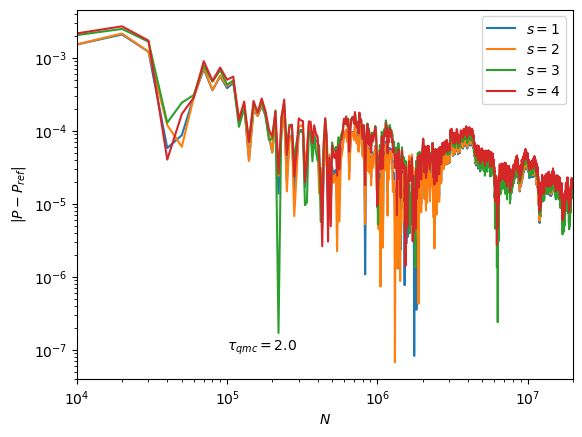

In [13]:
ref =[-0.0388306208024902, -0.0388306208024902, -0.0428458702224106, -0.0428458702224105]

div = results - (ref .* ones(Float64, N_points)')

h5_write_results("tau_qmc_$τ_qmc", ref, τ_qmc, N_list, results, div)

for s=1:4
    plt.loglog(N_list, abs.(div[s, :]), label = "\$s=$s\$")
end
plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_list[1], N_list[end])
plt.legend()
plt.text(1e5, 1e-7, "\$\\tau_{qmc} = $τ_qmc\$")

plt.savefig("2nd_order_inchworm_tau$τ_qmc.pdf")

In [42]:
# Test a single value of the integrand

τ = [tau_grid[end-20].bpoint, tau_grid[end-30].bpoint, tau_grid[end-40].bpoint]
@show τ

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
println(s)

τ = Keldysh.BranchPoint[Keldysh.BranchPoint(0.0 - 6.0im, 0.6, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 4.0im, 0.4, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 2.0im, 0.2, Keldysh.imaginary_branch)]
Δ(n_f.time, τ[2]) = 0.0 - 0.14260106795208327im
Δ(τ[2], n_f.time) = 0.0 + 0.14260106795208327im
Δ(τ[1], τ[3]) = 0.0 - 0.14260106795208327im
Δ(τ[3], τ[1]) = 0.0 + 0.14260106795208327im
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v3 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v4 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}(3 => (3, [0.0 + 0.0010433081399029316im]))
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}(1 => (1, [0.0 + 0.0005725796472103434im]))
v3 = 